In [79]:
import os
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.metrics import accuracy_score, confusion_matrix
from vision_models import Plot

In [80]:
data_dir = '.'  # Set the directory where your .npy files are located

# Initialize dictionaries to store training and test accuracy data for each model
model_train_data = {}
model_test_data = {}

test_true = np.load(os.path.join(data_dir, 'test_true.npy'))

# Loop through all files in the directory
for filename in os.listdir(data_dir):
    train_match = re.match(pattern=r'(.+?)_train_(loss|acc)_lr(.+?)_e(\d+?).npy',
                           string=filename)
    test_match = re.match(pattern=r'(.+?)_test_pred_lr(.+?)_e(\d+?).npy',
                          string=filename)

    if train_match:
        model_name = train_match.group(1)
        metric = train_match.group(2)
        lr_value = float(train_match.group(3))
        num_epochs = int(train_match.group(4)) + 1

        # Load the data from the .npy file
        data = np.load(os.path.join(data_dir, filename))

        # Store the data in the model_data dictionary
        if model_name not in model_train_data:
            model_train_data[model_name] = {}
        if metric not in model_train_data[model_name]:
            model_train_data[model_name][metric] = {}
        if lr_value not in model_train_data[model_name][metric]:
            model_train_data[model_name][metric][lr_value] = {}

        model_train_data[model_name][metric][lr_value][num_epochs] = data[-1]
    elif test_match:
        model_name = test_match.group(1)
        lr_value = float(test_match.group(2))
        num_epochs = int(test_match.group(3)) + 1

        # Load the test data from the .npy file
        test_pred = np.load(os.path.join(data_dir, filename))

        # Store the data in the model_test_data dictionary
        if model_name not in model_test_data:
            model_test_data[model_name] = {}
        if lr_value not in model_test_data[model_name]:
            model_test_data[model_name][lr_value] = {}

        model_test_data[model_name][lr_value][num_epochs] = \
            {'acc': accuracy_score(test_true, test_pred), 'cm': confusion_matrix(test_true, test_pred)}

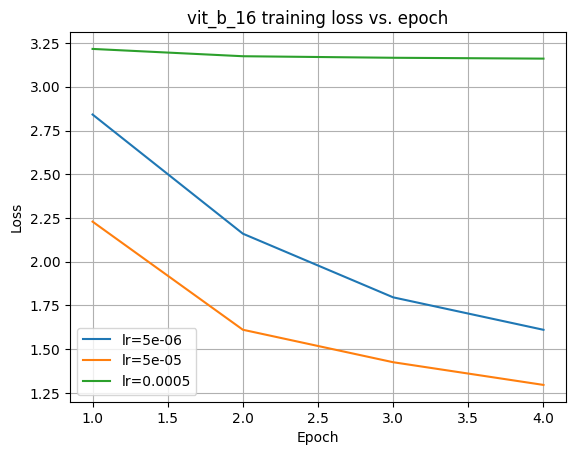

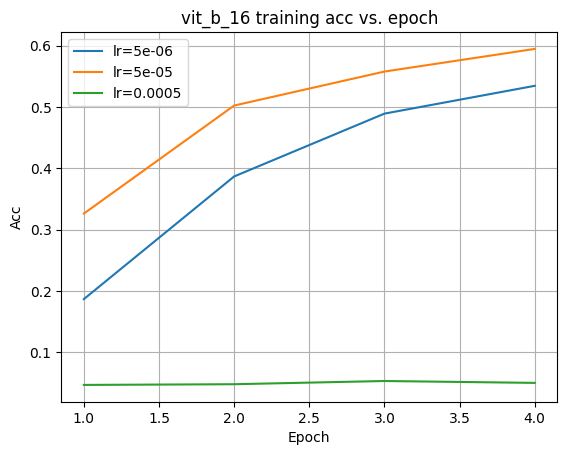

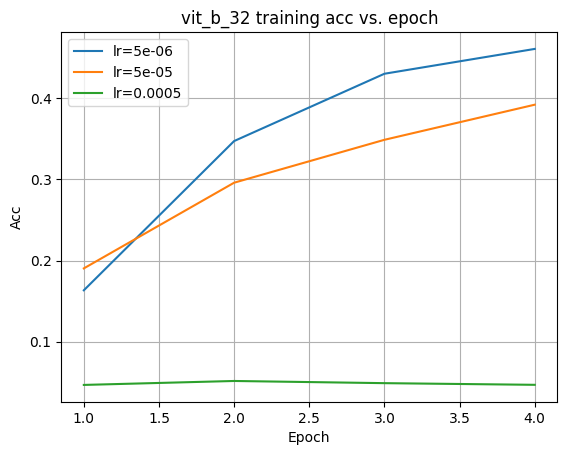

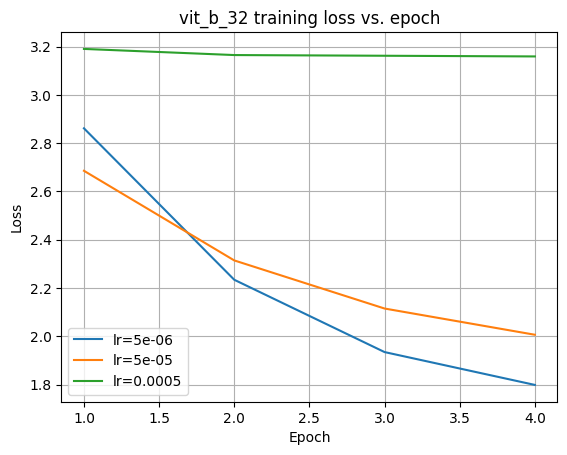

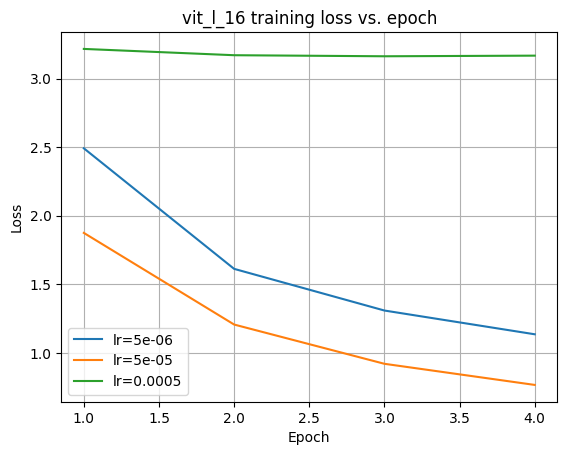

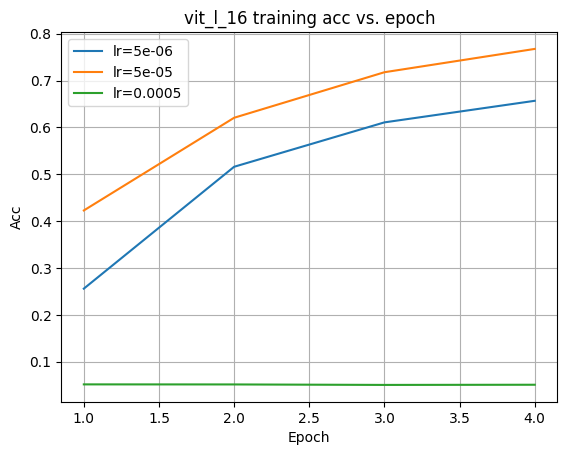

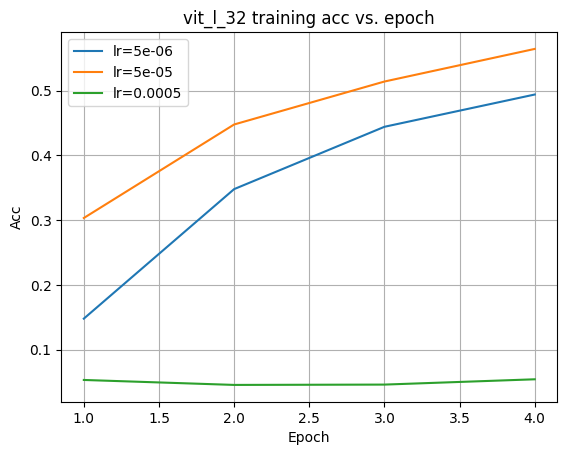

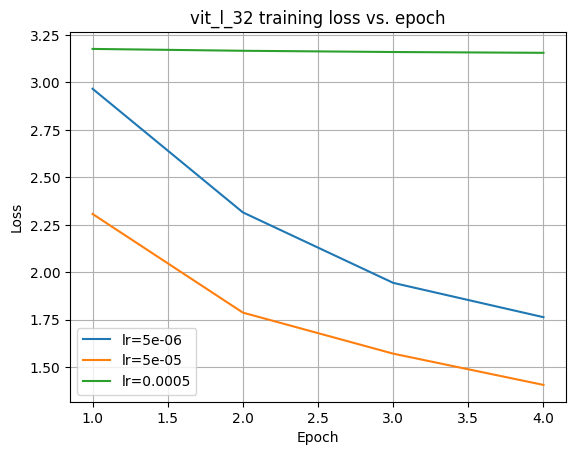

<Figure size 640x480 with 0 Axes>

In [82]:
def plot_train_metrics():
    # Create plots for training metric vs. epoch for each model
    for model_name, model_data in sorted(model_train_data.items()):
        for metric, metric_data in model_data.items():
            
            with Plot():
                plt.title(f"{model_name} training {metric} vs. epoch")
                plt.xlabel('Epoch')
                plt.ylabel(metric.capitalize())
    
                for lr_value, lr_data in sorted(metric_data.items()):
                    # Sort the data based on the number of epochs
                    epochs, data = zip(*sorted(lr_data.items()))
                    plt.plot(epochs, data, label=f'lr={lr_value}')
    
                plt.legend()
                plt.grid()

plot_train_metrics()

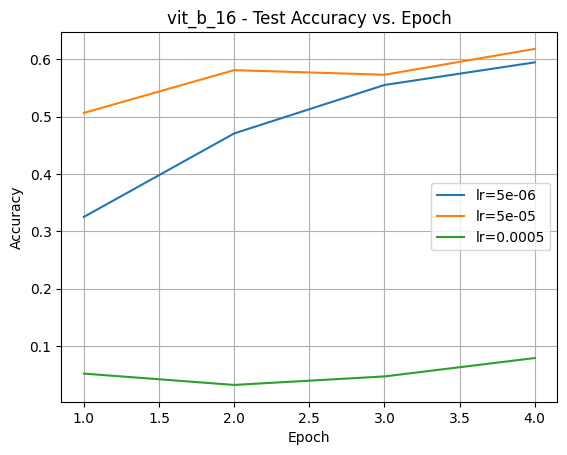

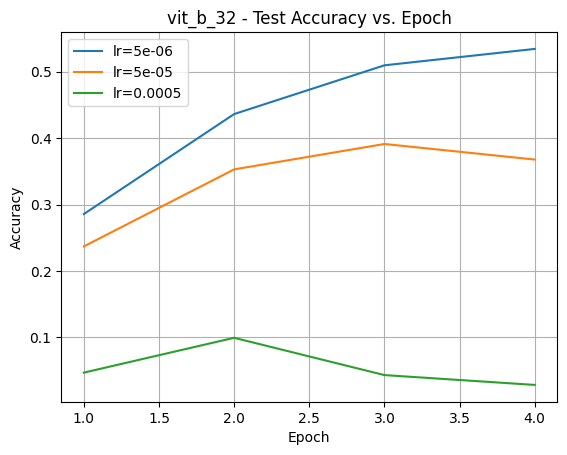

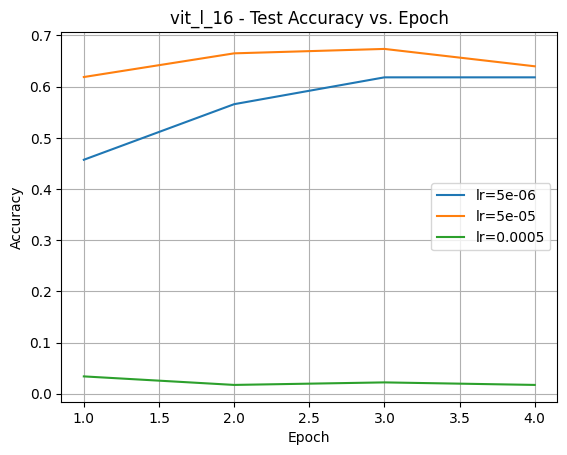

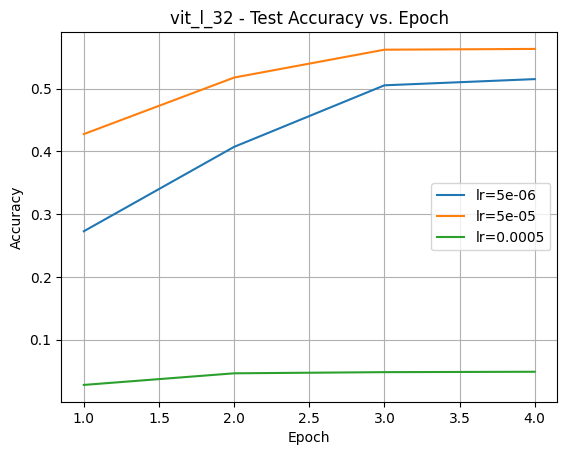

In [77]:
def plot_test_metrics():
    # Now, create plots for test accuracy vs. epoch for each model
    for model_name, model_data in sorted(model_test_data.items()):
        metric = 'Accuracy'
        plt.title(f"{model_name} - Test {metric} vs. Epoch")
        plt.xlabel('Epoch')
        plt.ylabel(metric)

        for lr_value, lr_data in sorted(model_data.items()):
            # Sort the data based on the number of epochs
            epochs, epoch_data = zip(*sorted(lr_data.items()))
            plt.plot(epochs, [curr_data['acc'] for curr_data in epoch_data], label=f'lr={lr_value}')

        plt.legend()
        plt.grid()
        plt.show()
        
        
plot_test_metrics()